# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from model_components.synth_data import SyntheticTimeSeriesDataset
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 64      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 1

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 128
  d_ff                      : 64
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 2
  num_heads                 : 66
  dropout                   : 0.4

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : True   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# # create fake data for testing transformer
# # Create dataset
# train_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='train',
#     noise_std=0.05,
#     num_frequencies=2
# )

# val_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='val',
#     noise_std=0.05,
#     num_frequencies=2
# )

# # Sample visualization will auto-show
# print(train_dataset[0][0].shape)  # Should be [30, 1]
# print(train_dataset[0][1].shape)  # Should be [5, 1]

In [5]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='train',
    val_ratio=0.15,
    fit_scaler=True
)
tgt_scaler = train_dataset.tgt_scaler
cls_scaler = train_dataset.cls_scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='val',
    val_ratio=0.15,
    tgt_scaler=tgt_scaler,
    cls_scaler=cls_scaler
)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.025063  0.022758  0.020406  0.289462
2015-01-05  0.020931  0.019052  0.017820  0.361694
2015-01-06  0.018597  0.017431  0.016780  0.371548
2015-01-07  0.019477  0.018454  0.019540  0.204077
2015-01-08  0.022184  0.023701  0.022206  0.329616
after normalization dataset is Date
2015-01-02    0.021795
2015-01-05    0.017699
2015-01-06    0.017712
2015-01-07    0.019694
2015-01-08    0.025199
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object')


Processing AAPL (train): 100%|█████████████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 35916.43it/s]
[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2023-06-30  1.015151  1.026109  1.013786  0.081277
2023-07-03  1.027926  1.022556  1.016757 -0.006091
2023-07-05  1.014795  1.017228  1.009983  0.019107
2023-07-06  1.004516  1.011545  1.001545  0.016131
2023-07-07  1.013844  1.015393  1.007725  0.018875
after normalization dataset is Date
2023-06-30    1.025958
2023-07-03    1.017009
2023-07-05    1.010312
2023-07-06    1.013157
2023-07-07    1.006460
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object')


Processing AAPL (val): 100%|█████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 71160.85it/s]


In [6]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [7]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets[0].shape))
    print(targets[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets.shape)
    break

outputs = model(inputs)  # or model(inputs, something_else) if needed
print(outputs.shape)

model_stats = summary(model, input_data=inputs.to("cpu"), device="cpu")
print(model_stats)

6 1
First input sample (shape: torch.Size([5, 6])):
tensor([[0.0251, 0.0228, 0.0204, 0.0218, 0.2895, 0.0000],
        [0.0209, 0.0191, 0.0178, 0.0177, 0.3617, 1.0000],
        [0.0186, 0.0174, 0.0168, 0.0177, 0.3715, 2.0000],
        [0.0195, 0.0185, 0.0195, 0.0197, 0.2041, 3.0000],
        [0.0222, 0.0237, 0.0222, 0.0252, 0.3296, 4.0000]])
Corresponding target (shape: torch.Size([1, 1])):
tensor([[0.0254]])
Inputs: torch.Size([64, 5, 6])
Targets: torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [64, 1, 1]                257
├─Linear: 1-1                                 [64, 5, 128]              768
├─GELU: 1-2                                   [64, 5, 128]              --
├─Time2VecTorch: 1-3                          [64, 5, 4]                8
├─TimeSeriesPositionalEncoding: 1-4           [64, 5, 132]              --
├─Dropout: 1-5                                

# STEP 3: Setup WandB and Trainer

In [8]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc
wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
# wandb.finish()

In [10]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    scaler=tgt_scaler,
    device=device
)
print("done with init!")

True
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (255 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (85 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


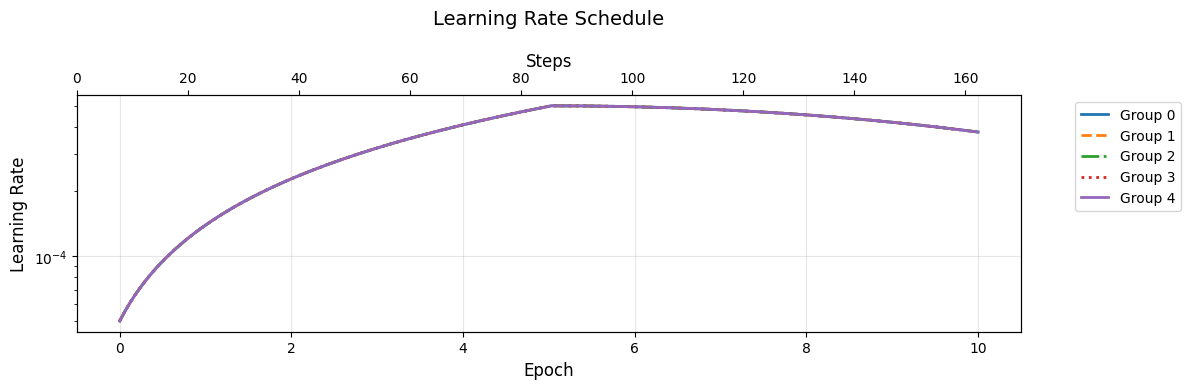

In [11]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
if trainer.use_wandb:
    wandb.init(
        project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
        config=trainer.config,
        name=trainer.run_name,
        settings=wandb.Settings(
        start_method="thread",             # don't spawn multiprocessing process
        )
    )


# Step 4: TRAIN!!   

In [12]:
print("here!")
trainer.train(train_loader, val_loader, epochs=50)

here!


Training:   0%|                                                                                        | 0/17 [00:00<?, ?it/s]/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAbsoluteError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 25.05it/s, batch_accuracy=4.76%, loss=38.8707, mae=nan]
wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Logging metrics: {'epoch': 1, 'train': {'train_loss': 81.39997304089745, 'train_mae': nan, 'train_accuracy': 0.28142589118198874}}
splitting train
metrics {'train_loss': 81.39997304089745, 'train_mae': nan, 'train_accuracy': 0.28142589118198874}

📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 81.4000 | train_mae: nan | train_accuracy: 0.2814


Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 42.80it/s, batch_accuracy=0.00%, loss=28.8555, mae=nan]


Logging metrics: {'epoch': 2, 'train': {'train_loss': 41.71907273555562, 'train_mae': nan, 'train_accuracy': 0.09380863039399624}}
splitting train
metrics {'train_loss': 41.71907273555562, 'train_mae': nan, 'train_accuracy': 0.09380863039399624}

📈 Epoch 1 Metrics:
  TRAIN      | train_loss: 41.7191 | train_mae: nan | train_accuracy: 0.0938


Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 43.12it/s, batch_accuracy=0.00%, loss=26.1713, mae=nan]


Logging metrics: {'epoch': 3, 'train': {'train_loss': 29.152170760993886, 'train_mae': nan, 'train_accuracy': 0.46904315196998125}}
splitting train
metrics {'train_loss': 29.152170760993886, 'train_mae': nan, 'train_accuracy': 0.46904315196998125}

📈 Epoch 2 Metrics:
  TRAIN      | train_loss: 29.1522 | train_mae: nan | train_accuracy: 0.4690


Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 42.82it/s, batch_accuracy=2.38%, loss=20.4589, mae=nan]


Logging metrics: {'epoch': 4, 'train': {'train_loss': 22.038037155179996, 'train_mae': nan, 'train_accuracy': 0.6566604127579737}}
splitting train
metrics {'train_loss': 22.038037155179996, 'train_mae': nan, 'train_accuracy': 0.6566604127579737}

📈 Epoch 3 Metrics:
  TRAIN      | train_loss: 22.0380 | train_mae: nan | train_accuracy: 0.6567


Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 42.86it/s, batch_accuracy=0.00%, loss=14.0916, mae=nan]


Logging metrics: {'epoch': 5, 'train': {'train_loss': 18.509388660624147, 'train_mae': nan, 'train_accuracy': 0.5628517823639775}}
splitting train
metrics {'train_loss': 18.509388660624147, 'train_mae': nan, 'train_accuracy': 0.5628517823639775}

📈 Epoch 4 Metrics:
  TRAIN      | train_loss: 18.5094 | train_mae: nan | train_accuracy: 0.5629


Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 42.93it/s, batch_accuracy=2.38%, loss=12.3034, mae=nan]


Logging metrics: {'epoch': 6, 'train': {'train_loss': 14.960373755020228, 'train_mae': nan, 'train_accuracy': 1.3133208255159474}}
splitting train
metrics {'train_loss': 14.960373755020228, 'train_mae': nan, 'train_accuracy': 1.3133208255159474}

📈 Epoch 5 Metrics:
  TRAIN      | train_loss: 14.9604 | train_mae: nan | train_accuracy: 1.3133


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.88it/s, batch_accuracy=0.00%, loss=9.1117, mae=nan]


Logging metrics: {'epoch': 7, 'train': {'train_loss': 12.033991287617924, 'train_mae': nan, 'train_accuracy': 0.6566604127579737}}
splitting train
metrics {'train_loss': 12.033991287617924, 'train_mae': nan, 'train_accuracy': 0.6566604127579737}

📈 Epoch 6 Metrics:
  TRAIN      | train_loss: 12.0340 | train_mae: nan | train_accuracy: 0.6567


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.67it/s, batch_accuracy=4.76%, loss=6.1863, mae=nan]


Logging metrics: {'epoch': 8, 'train': {'train_loss': 9.535935483327727, 'train_mae': nan, 'train_accuracy': 1.5009380863039399}}
splitting train
metrics {'train_loss': 9.535935483327727, 'train_mae': nan, 'train_accuracy': 1.5009380863039399}

📈 Epoch 7 Metrics:
  TRAIN      | train_loss: 9.5359 | train_mae: nan | train_accuracy: 1.5009


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.89it/s, batch_accuracy=2.38%, loss=7.3701, mae=nan]


Logging metrics: {'epoch': 9, 'train': {'train_loss': 9.211607861474128, 'train_mae': nan, 'train_accuracy': 0.9380863039399625}}
splitting train
metrics {'train_loss': 9.211607861474128, 'train_mae': nan, 'train_accuracy': 0.9380863039399625}

📈 Epoch 8 Metrics:
  TRAIN      | train_loss: 9.2116 | train_mae: nan | train_accuracy: 0.9381


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.59it/s, batch_accuracy=2.38%, loss=5.8533, mae=nan]


Logging metrics: {'epoch': 10, 'train': {'train_loss': 6.542955641003979, 'train_mae': nan, 'train_accuracy': 1.4071294559099436}}
splitting train
metrics {'train_loss': 6.542955641003979, 'train_mae': nan, 'train_accuracy': 1.4071294559099436}

📈 Epoch 9 Metrics:
  TRAIN      | train_loss: 6.5430 | train_mae: nan | train_accuracy: 1.4071


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.96it/s, batch_accuracy=0.00%, loss=5.4390, mae=nan]


Logging metrics: {'epoch': 11, 'train': {'train_loss': 6.088633275166238, 'train_mae': nan, 'train_accuracy': 0.9380863039399625}}
splitting train
metrics {'train_loss': 6.088633275166238, 'train_mae': nan, 'train_accuracy': 0.9380863039399625}

📈 Epoch 10 Metrics:
  TRAIN      | train_loss: 6.0886 | train_mae: nan | train_accuracy: 0.9381


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.27it/s, batch_accuracy=0.00%, loss=4.2395, mae=nan]


Logging metrics: {'epoch': 12, 'train': {'train_loss': 5.518182835033195, 'train_mae': nan, 'train_accuracy': 1.125703564727955}}
splitting train
metrics {'train_loss': 5.518182835033195, 'train_mae': nan, 'train_accuracy': 1.125703564727955}

📈 Epoch 11 Metrics:
  TRAIN      | train_loss: 5.5182 | train_mae: nan | train_accuracy: 1.1257


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.26it/s, batch_accuracy=2.38%, loss=4.4491, mae=nan]


Logging metrics: {'epoch': 13, 'train': {'train_loss': 4.565956597032958, 'train_mae': nan, 'train_accuracy': 1.4071294559099436}}
splitting train
metrics {'train_loss': 4.565956597032958, 'train_mae': nan, 'train_accuracy': 1.4071294559099436}

📈 Epoch 12 Metrics:
  TRAIN      | train_loss: 4.5660 | train_mae: nan | train_accuracy: 1.4071


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.58it/s, batch_accuracy=4.76%, loss=4.1634, mae=nan]


Logging metrics: {'epoch': 14, 'train': {'train_loss': 4.437143802642822, 'train_mae': nan, 'train_accuracy': 1.594746716697936}}
splitting train
metrics {'train_loss': 4.437143802642822, 'train_mae': nan, 'train_accuracy': 1.594746716697936}

📈 Epoch 13 Metrics:
  TRAIN      | train_loss: 4.4371 | train_mae: nan | train_accuracy: 1.5947


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.26it/s, batch_accuracy=4.76%, loss=4.2775, mae=nan]


Logging metrics: {'epoch': 15, 'train': {'train_loss': 3.60223660370646, 'train_mae': nan, 'train_accuracy': 1.3133208255159474}}
splitting train
metrics {'train_loss': 3.60223660370646, 'train_mae': nan, 'train_accuracy': 1.3133208255159474}

📈 Epoch 14 Metrics:
  TRAIN      | train_loss: 3.6022 | train_mae: nan | train_accuracy: 1.3133


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.19it/s, batch_accuracy=4.76%, loss=1.8503, mae=nan]


Logging metrics: {'epoch': 16, 'train': {'train_loss': 3.1290336326184014, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}}
splitting train
metrics {'train_loss': 3.1290336326184014, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}

📈 Epoch 15 Metrics:
  TRAIN      | train_loss: 3.1290 | train_mae: nan | train_accuracy: 2.1576


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.97it/s, batch_accuracy=0.00%, loss=3.7360, mae=nan]


Logging metrics: {'epoch': 17, 'train': {'train_loss': 2.8384028152050713, 'train_mae': nan, 'train_accuracy': 0.5628517823639775}}
splitting train
metrics {'train_loss': 2.8384028152050713, 'train_mae': nan, 'train_accuracy': 0.5628517823639775}

📈 Epoch 16 Metrics:
  TRAIN      | train_loss: 2.8384 | train_mae: nan | train_accuracy: 0.5629


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.93it/s, batch_accuracy=2.38%, loss=3.2833, mae=nan]


Logging metrics: {'epoch': 18, 'train': {'train_loss': 2.660718322918518, 'train_mae': nan, 'train_accuracy': 1.7823639774859288}}
splitting train
metrics {'train_loss': 2.660718322918518, 'train_mae': nan, 'train_accuracy': 1.7823639774859288}

📈 Epoch 17 Metrics:
  TRAIN      | train_loss: 2.6607 | train_mae: nan | train_accuracy: 1.7824


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.41it/s, batch_accuracy=2.38%, loss=2.2059, mae=nan]


Logging metrics: {'epoch': 19, 'train': {'train_loss': 2.3276469649338143, 'train_mae': nan, 'train_accuracy': 1.4071294559099436}}
splitting train
metrics {'train_loss': 2.3276469649338143, 'train_mae': nan, 'train_accuracy': 1.4071294559099436}

📈 Epoch 18 Metrics:
  TRAIN      | train_loss: 2.3276 | train_mae: nan | train_accuracy: 1.4071


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.87it/s, batch_accuracy=4.76%, loss=1.6221, mae=nan]


Logging metrics: {'epoch': 20, 'train': {'train_loss': 2.1833771941362135, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}}
splitting train
metrics {'train_loss': 2.1833771941362135, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}

📈 Epoch 19 Metrics:
  TRAIN      | train_loss: 2.1834 | train_mae: nan | train_accuracy: 2.1576


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.08it/s, batch_accuracy=0.00%, loss=2.6037, mae=nan]


Logging metrics: {'epoch': 21, 'train': {'train_loss': 2.095189952939805, 'train_mae': nan, 'train_accuracy': 1.7823639774859288}}
splitting train
metrics {'train_loss': 2.095189952939805, 'train_mae': nan, 'train_accuracy': 1.7823639774859288}

📈 Epoch 20 Metrics:
  TRAIN      | train_loss: 2.0952 | train_mae: nan | train_accuracy: 1.7824


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.85it/s, batch_accuracy=4.76%, loss=1.6509, mae=nan]


Logging metrics: {'epoch': 22, 'train': {'train_loss': 1.8333384753615503, 'train_mae': nan, 'train_accuracy': 1.594746716697936}}
splitting train
metrics {'train_loss': 1.8333384753615503, 'train_mae': nan, 'train_accuracy': 1.594746716697936}

📈 Epoch 21 Metrics:
  TRAIN      | train_loss: 1.8333 | train_mae: nan | train_accuracy: 1.5947


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.78it/s, batch_accuracy=7.14%, loss=1.4433, mae=nan]


Logging metrics: {'epoch': 23, 'train': {'train_loss': 1.797693920627544, 'train_mae': nan, 'train_accuracy': 1.9699812382739212}}
splitting train
metrics {'train_loss': 1.797693920627544, 'train_mae': nan, 'train_accuracy': 1.9699812382739212}

📈 Epoch 22 Metrics:
  TRAIN      | train_loss: 1.7977 | train_mae: nan | train_accuracy: 1.9700


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.99it/s, batch_accuracy=9.52%, loss=1.2723, mae=nan]


Logging metrics: {'epoch': 24, 'train': {'train_loss': 1.7167518863534839, 'train_mae': nan, 'train_accuracy': 2.25140712945591}}
splitting train
metrics {'train_loss': 1.7167518863534839, 'train_mae': nan, 'train_accuracy': 2.25140712945591}

📈 Epoch 23 Metrics:
  TRAIN      | train_loss: 1.7168 | train_mae: nan | train_accuracy: 2.2514


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.80it/s, batch_accuracy=7.14%, loss=1.3384, mae=nan]


Logging metrics: {'epoch': 25, 'train': {'train_loss': 1.8186644678044275, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}}
splitting train
metrics {'train_loss': 1.8186644678044275, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}

📈 Epoch 24 Metrics:
  TRAIN      | train_loss: 1.8187 | train_mae: nan | train_accuracy: 2.1576


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.77it/s, batch_accuracy=7.14%, loss=0.7648, mae=nan]


Logging metrics: {'epoch': 26, 'train': {'train_loss': 1.5814668179452978, 'train_mae': nan, 'train_accuracy': 2.720450281425891}}
splitting train
metrics {'train_loss': 1.5814668179452978, 'train_mae': nan, 'train_accuracy': 2.720450281425891}

📈 Epoch 25 Metrics:
  TRAIN      | train_loss: 1.5815 | train_mae: nan | train_accuracy: 2.7205


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.94it/s, batch_accuracy=2.38%, loss=0.9976, mae=nan]


Logging metrics: {'epoch': 27, 'train': {'train_loss': 1.3505438220657506, 'train_mae': nan, 'train_accuracy': 2.4390243902439024}}
splitting train
metrics {'train_loss': 1.3505438220657506, 'train_mae': nan, 'train_accuracy': 2.4390243902439024}

📈 Epoch 26 Metrics:
  TRAIN      | train_loss: 1.3505 | train_mae: nan | train_accuracy: 2.4390


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.27it/s, batch_accuracy=4.76%, loss=1.3876, mae=nan]


Logging metrics: {'epoch': 28, 'train': {'train_loss': 1.3384042768048972, 'train_mae': nan, 'train_accuracy': 1.7823639774859288}}
splitting train
metrics {'train_loss': 1.3384042768048972, 'train_mae': nan, 'train_accuracy': 1.7823639774859288}

📈 Epoch 27 Metrics:
  TRAIN      | train_loss: 1.3384 | train_mae: nan | train_accuracy: 1.7824


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.02it/s, batch_accuracy=0.00%, loss=1.0239, mae=nan]


Logging metrics: {'epoch': 29, 'train': {'train_loss': 1.3894427538365406, 'train_mae': nan, 'train_accuracy': 1.6885553470919326}}
splitting train
metrics {'train_loss': 1.3894427538365406, 'train_mae': nan, 'train_accuracy': 1.6885553470919326}

📈 Epoch 28 Metrics:
  TRAIN      | train_loss: 1.3894 | train_mae: nan | train_accuracy: 1.6886


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.38it/s, batch_accuracy=4.76%, loss=1.0679, mae=nan]


Logging metrics: {'epoch': 30, 'train': {'train_loss': 1.3662442637652885, 'train_mae': nan, 'train_accuracy': 2.5328330206378986}}
splitting train
metrics {'train_loss': 1.3662442637652885, 'train_mae': nan, 'train_accuracy': 2.5328330206378986}

📈 Epoch 29 Metrics:
  TRAIN      | train_loss: 1.3662 | train_mae: nan | train_accuracy: 2.5328


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.10it/s, batch_accuracy=2.38%, loss=1.0658, mae=nan]


Logging metrics: {'epoch': 31, 'train': {'train_loss': 1.326563080748295, 'train_mae': nan, 'train_accuracy': 2.0637898686679175}}
splitting train
metrics {'train_loss': 1.326563080748295, 'train_mae': nan, 'train_accuracy': 2.0637898686679175}

📈 Epoch 30 Metrics:
  TRAIN      | train_loss: 1.3266 | train_mae: nan | train_accuracy: 2.0638


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.89it/s, batch_accuracy=7.14%, loss=1.6037, mae=nan]


Logging metrics: {'epoch': 32, 'train': {'train_loss': 1.2206771210479022, 'train_mae': nan, 'train_accuracy': 1.5009380863039399}}
splitting train
metrics {'train_loss': 1.2206771210479022, 'train_mae': nan, 'train_accuracy': 1.5009380863039399}

📈 Epoch 31 Metrics:
  TRAIN      | train_loss: 1.2207 | train_mae: nan | train_accuracy: 1.5009


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.94it/s, batch_accuracy=7.14%, loss=0.6599, mae=nan]


Logging metrics: {'epoch': 33, 'train': {'train_loss': 1.3578910947293323, 'train_mae': nan, 'train_accuracy': 1.5009380863039399}}
splitting train
metrics {'train_loss': 1.3578910947293323, 'train_mae': nan, 'train_accuracy': 1.5009380863039399}

📈 Epoch 32 Metrics:
  TRAIN      | train_loss: 1.3579 | train_mae: nan | train_accuracy: 1.5009


Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 42.92it/s, batch_accuracy=14.29%, loss=0.9371, mae=nan]


Logging metrics: {'epoch': 34, 'train': {'train_loss': 1.399558673768285, 'train_mae': nan, 'train_accuracy': 2.4390243902439024}}
splitting train
metrics {'train_loss': 1.399558673768285, 'train_mae': nan, 'train_accuracy': 2.4390243902439024}

📈 Epoch 33 Metrics:
  TRAIN      | train_loss: 1.3996 | train_mae: nan | train_accuracy: 2.4390


Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 42.92it/s, batch_accuracy=11.90%, loss=1.2414, mae=nan]


Logging metrics: {'epoch': 35, 'train': {'train_loss': 1.2387693706641278, 'train_mae': nan, 'train_accuracy': 1.9699812382739212}}
splitting train
metrics {'train_loss': 1.2387693706641278, 'train_mae': nan, 'train_accuracy': 1.9699812382739212}

📈 Epoch 34 Metrics:
  TRAIN      | train_loss: 1.2388 | train_mae: nan | train_accuracy: 1.9700


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.98it/s, batch_accuracy=4.76%, loss=1.0057, mae=nan]


Logging metrics: {'epoch': 36, 'train': {'train_loss': 1.1946503702292524, 'train_mae': nan, 'train_accuracy': 1.7823639774859288}}
splitting train
metrics {'train_loss': 1.1946503702292524, 'train_mae': nan, 'train_accuracy': 1.7823639774859288}

📈 Epoch 35 Metrics:
  TRAIN      | train_loss: 1.1947 | train_mae: nan | train_accuracy: 1.7824


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.97it/s, batch_accuracy=7.14%, loss=0.7971, mae=nan]


Logging metrics: {'epoch': 37, 'train': {'train_loss': 1.05356477818838, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}}
splitting train
metrics {'train_loss': 1.05356477818838, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}

📈 Epoch 36 Metrics:
  TRAIN      | train_loss: 1.0536 | train_mae: nan | train_accuracy: 2.1576


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.63it/s, batch_accuracy=7.14%, loss=0.9638, mae=nan]


Logging metrics: {'epoch': 38, 'train': {'train_loss': 1.092659709713025, 'train_mae': nan, 'train_accuracy': 1.876172607879925}}
splitting train
metrics {'train_loss': 1.092659709713025, 'train_mae': nan, 'train_accuracy': 1.876172607879925}

📈 Epoch 37 Metrics:
  TRAIN      | train_loss: 1.0927 | train_mae: nan | train_accuracy: 1.8762


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.96it/s, batch_accuracy=7.14%, loss=0.8059, mae=nan]


Logging metrics: {'epoch': 39, 'train': {'train_loss': 1.1253998785036814, 'train_mae': nan, 'train_accuracy': 2.5328330206378986}}
splitting train
metrics {'train_loss': 1.1253998785036814, 'train_mae': nan, 'train_accuracy': 2.5328330206378986}

📈 Epoch 38 Metrics:
  TRAIN      | train_loss: 1.1254 | train_mae: nan | train_accuracy: 2.5328


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.91it/s, batch_accuracy=9.52%, loss=0.6202, mae=nan]


Logging metrics: {'epoch': 40, 'train': {'train_loss': 1.0865024908622256, 'train_mae': nan, 'train_accuracy': 2.626641651031895}}
splitting train
metrics {'train_loss': 1.0865024908622256, 'train_mae': nan, 'train_accuracy': 2.626641651031895}

📈 Epoch 39 Metrics:
  TRAIN      | train_loss: 1.0865 | train_mae: nan | train_accuracy: 2.6266


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.34it/s, batch_accuracy=9.52%, loss=0.4829, mae=nan]


Logging metrics: {'epoch': 41, 'train': {'train_loss': 0.976944751911718, 'train_mae': nan, 'train_accuracy': 2.345215759849906}}
splitting train
metrics {'train_loss': 0.976944751911718, 'train_mae': nan, 'train_accuracy': 2.345215759849906}

📈 Epoch 40 Metrics:
  TRAIN      | train_loss: 0.9769 | train_mae: nan | train_accuracy: 2.3452


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.21it/s, batch_accuracy=7.14%, loss=0.7120, mae=nan]


Logging metrics: {'epoch': 42, 'train': {'train_loss': 1.0083686834652026, 'train_mae': nan, 'train_accuracy': 1.6885553470919326}}
splitting train
metrics {'train_loss': 1.0083686834652026, 'train_mae': nan, 'train_accuracy': 1.6885553470919326}

📈 Epoch 41 Metrics:
  TRAIN      | train_loss: 1.0084 | train_mae: nan | train_accuracy: 1.6886


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.28it/s, batch_accuracy=4.76%, loss=0.7522, mae=nan]


Logging metrics: {'epoch': 43, 'train': {'train_loss': 0.9777279157352269, 'train_mae': nan, 'train_accuracy': 2.5328330206378986}}
splitting train
metrics {'train_loss': 0.9777279157352269, 'train_mae': nan, 'train_accuracy': 2.5328330206378986}

📈 Epoch 42 Metrics:
  TRAIN      | train_loss: 0.9777 | train_mae: nan | train_accuracy: 2.5328


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.04it/s, batch_accuracy=4.76%, loss=0.6137, mae=nan]


Logging metrics: {'epoch': 44, 'train': {'train_loss': 1.1082517967662489, 'train_mae': nan, 'train_accuracy': 2.0637898686679175}}
splitting train
metrics {'train_loss': 1.1082517967662489, 'train_mae': nan, 'train_accuracy': 2.0637898686679175}

📈 Epoch 43 Metrics:
  TRAIN      | train_loss: 1.1083 | train_mae: nan | train_accuracy: 2.0638


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.07it/s, batch_accuracy=4.76%, loss=0.6096, mae=nan]


Logging metrics: {'epoch': 45, 'train': {'train_loss': 1.1568765582107916, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}}
splitting train
metrics {'train_loss': 1.1568765582107916, 'train_mae': nan, 'train_accuracy': 2.1575984990619137}

📈 Epoch 44 Metrics:
  TRAIN      | train_loss: 1.1569 | train_mae: nan | train_accuracy: 2.1576


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.32it/s, batch_accuracy=4.76%, loss=0.5885, mae=nan]


Logging metrics: {'epoch': 46, 'train': {'train_loss': 0.9637226135824679, 'train_mae': nan, 'train_accuracy': 2.5328330206378986}}
splitting train
metrics {'train_loss': 0.9637226135824679, 'train_mae': nan, 'train_accuracy': 2.5328330206378986}

📈 Epoch 45 Metrics:
  TRAIN      | train_loss: 0.9637 | train_mae: nan | train_accuracy: 2.5328


Training: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 43.16it/s, batch_accuracy=16.67%, loss=0.5174, mae=nan]


Logging metrics: {'epoch': 47, 'train': {'train_loss': 0.9601121320062462, 'train_mae': nan, 'train_accuracy': 2.25140712945591}}
splitting train
metrics {'train_loss': 0.9601121320062462, 'train_mae': nan, 'train_accuracy': 2.25140712945591}

📈 Epoch 46 Metrics:
  TRAIN      | train_loss: 0.9601 | train_mae: nan | train_accuracy: 2.2514


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.96it/s, batch_accuracy=7.14%, loss=0.3761, mae=nan]


Logging metrics: {'epoch': 48, 'train': {'train_loss': 0.9524113673430222, 'train_mae': nan, 'train_accuracy': 1.876172607879925}}
splitting train
metrics {'train_loss': 0.9524113673430222, 'train_mae': nan, 'train_accuracy': 1.876172607879925}

📈 Epoch 47 Metrics:
  TRAIN      | train_loss: 0.9524 | train_mae: nan | train_accuracy: 1.8762


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 42.64it/s, batch_accuracy=9.52%, loss=0.4975, mae=nan]


Logging metrics: {'epoch': 49, 'train': {'train_loss': 0.995611140528942, 'train_mae': nan, 'train_accuracy': 2.4390243902439024}}
splitting train
metrics {'train_loss': 0.995611140528942, 'train_mae': nan, 'train_accuracy': 2.4390243902439024}

📈 Epoch 48 Metrics:
  TRAIN      | train_loss: 0.9956 | train_mae: nan | train_accuracy: 2.4390


Training: 100%|███████████████████████████████████| 17/17 [00:00<00:00, 43.03it/s, batch_accuracy=9.52%, loss=0.4952, mae=nan]


Logging metrics: {'epoch': 50, 'train': {'train_loss': 0.9527437403993804, 'train_mae': nan, 'train_accuracy': 1.6885553470919326}}
splitting train
metrics {'train_loss': 0.9527437403993804, 'train_mae': nan, 'train_accuracy': 1.6885553470919326}

📈 Epoch 49 Metrics:
  TRAIN      | train_loss: 0.9527 | train_mae: nan | train_accuracy: 1.6886


here!


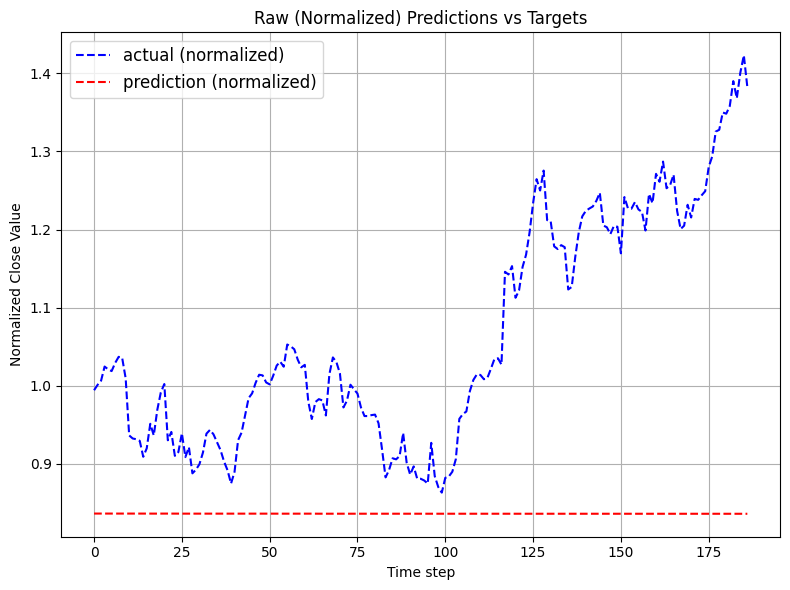

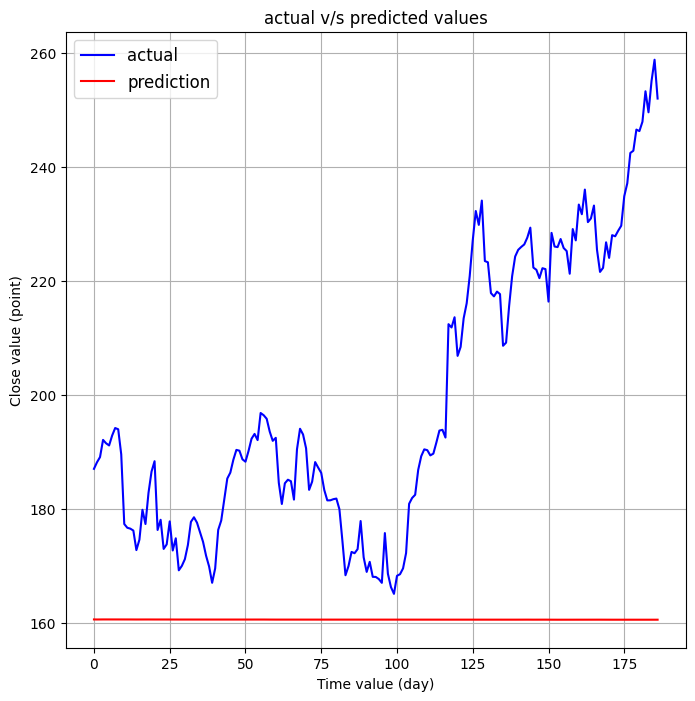

{'val_loss': 0.07284103533163427,
 'val_mae': 0.22738192975521088,
 'val_accuracy': 0.0}

In [13]:
print("here!")
trainer.evaluate(val_loader)